In [1]:
import os
import cv2

from helpers.dataset_process import dataset_to_df, search_df

import numpy as np
# import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
from torch import nn, einsum
import torch.nn.functional as F


# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
model_type = "vit"
add_extra_epochs = True  # if True then continue for extra epochs from the starting epoch
# If True load a pretrained model, and start_epoch = epoch of the model . Else if False then start_epoch = 0
start_from_model = False

In [4]:
model_state_path = f"../../../weights/{model_type}_cifak/checkpoint/"

# model_file_name = f"vit_patch8_cifak_epoch_263"  # file name of the saved model

# checkpoint = torch.load(model_state_path+model_file_name)

In [5]:
img_size = 32  # Input image height/width in pixels
patch_size = 8 # The height/width of a patch in pixels (patch is a slice of an image)

image_patch_flat_size = 3*patch_size**2 #3 Channels x height x width
embed_size = image_patch_flat_size
mlp_dim = 384 # dim of the last mlp classifier

downscaling_factor=(2, 2, 2, 1) # used for swin

train_batch_size = 256 # https://www.youtube.com/watch?v=Owm1H0ukjS4
valid_batch_size = 256

num_classes = 2
encoder_depth = 9
attention_heads = 12

print(f'Flattened dimension size(of a patch): {image_patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 192
Embedding Size: 192
Output MLP size: 384


In [6]:
n_extra_epochs = 20
max_epochs = 200

start_epoch = checkpoint['epoch'] if start_from_model else 0
end_epoch = start_epoch + n_extra_epochs if add_extra_epochs else max_epochs
delta_epochs = end_epoch-start_epoch

print(f"Train another {delta_epochs} epochs after epoch {start_epoch} ")

Train another 20 epochs after epoch 0 


In [7]:
base_lr = 0.0005         # Base Learning rate 0.1 for SGD , 0.0001 for Adam
momentum = 0.9          # Momentum for SGD
weight_decay = 0.03     # Weight decay for Adam


loss_algo = CrossEntropyLoss

optimize_algo = SGD
optimize_args = {"lr": base_lr,
                #  "weight_decay": weight_decay,
                #  "momentum": momentum  # comment momentum for Adam
                 }

use_scheduler = False
schedule_algo = CosineAnnealingLR
schedule_args = {"T_max": delta_epochs}

In [8]:
path = '../../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

In [9]:
df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(path, relative_paths, paths_classes, 0.8, 0.19, 0.01)
classes_stats

,REAL,FAKE,Total
Training,48000,48000,96000
Validation,11400,11400,22800
Testing,600,600,1200
Row_Total,60000,60000,120000


In [10]:
print("First and Last Elements in the Whole dataset")
df_all.iloc[[0,-1]]

First and Last Elements in the Whole dataset


,Image_path,Image_size,Class,Class_Codes,Class_Onehot
0,../../../data/CIFAK//train/REAL/0000(10).jpg,"(3, 32, 32)",REAL,1,"[1, 0]"
119999,../../../data/CIFAK//test/FAKE/999.jpg,"(3, 32, 32)",FAKE,0,"[0, 1]"


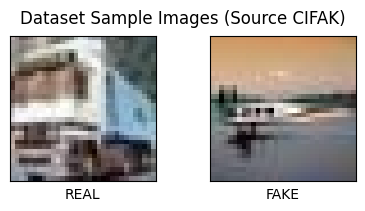

In [11]:
fig, axs = plt.subplots(1, 2, layout="constrained",figsize=(4, 2))

fig.suptitle('Dataset Sample Images (Source CIFAK)')
axs[0].imshow(cv2.imread(df_all.iloc[0, 0]))
axs[0].set(xlabel=df_all.iloc[0, 2])
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(cv2.imread(df_all.iloc[-1, 0]))
axs[1].set(xlabel=df_all.iloc[-1, 2])
axs[1].set_xticks([])
axs[1].set_yticks([])


plt.show()

In [12]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)


class MHA(nn.Module):
    def __init__(self, embed_dim: int, num_of_head: int = 12, Dropout=0.2) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.inner_dim = embed_dim*2
        self.num_of_head = num_of_head
        self.dim_per_head = self.inner_dim // self.num_of_head
        self.Wq = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wk = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wv = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        # self.dropout=nn.Dropout(p=Dropout)
        self.dropout = Dropout
        self.linear = nn.Linear(in_features=self.inner_dim, out_features=embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        Q = rearrange(q, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        K = rearrange(k, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        V = rearrange(v, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)

        use_dropout = 0.0 if not self.training else self.dropout

        attention = F.scaled_dot_product_attention(Q, K, V, dropout_p=use_dropout)
        # # Q(b h s d) . KT(b h d s) ==> b h s s
        # # qk = torch.matmul(q, k.transpose(-2, -1)) / (self.dim_per_head**0.5)
        # qk = torch.matmul(q, k.transpose(-2, -1)) / (self.embed_dim**0.5)

        # #  b h s s ==> b h s s
        # weight = F.softmax(qk, dim=1)
        # # weight_dropout=self.dropout(weight)

        # #weight(b h s s).V(b h s d) ==> attention (b h s d)
        # attention = torch.matmul(weight, v)
        # # attention = torch.matmul(weight_dropout, v)

        attention = rearrange(attention, 'b h s d -> b s (h d)')
        attention = self.linear(attention)
        return attention


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                # PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, MHA(embed_dim=dim, num_of_head=heads, Dropout=dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class vit(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, emb_dropout=0., dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * \
            (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {
            'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                      p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [13]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):
        
        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):
        
        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(self.annotation.iloc[index, 3],dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)

        return img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [14]:
norm_mean = [0.4913997551666284, 0.48215855929893703, 0.4465309133731618]
norm_std = [0.24703225141799082, 0.24348516474564, 0.26158783926049628]

In [15]:
transform_train = transforms.Compose([
    # v2.ToPILImage(),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
    # transforms.RandAugment(2, 14),
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAffine(degrees=(0, 180), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    # v2.RandomPerspective(distortion_scale=0.6, p=1.0),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    # v2.ToTensor(),
    v2.Normalize(norm_mean, norm_std),
])

transform_valid = transforms.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(norm_mean, norm_std),
])

In [16]:
# Define the dataset object and configure the Data Loader

train_set  = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set  = Images_Dataset(df_val, transform_valid)

valid_loader= DataLoader(dataset=valid_set ,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [17]:
print("Total number of training batches:", len(train_loader))
print("Total number of validation batches:", len(valid_loader))

Total number of training batches: 375
Total number of validation batches: 89


In [18]:
sample_img_batch,label = next(iter(train_loader))

print(f"Batch of Images Shape: {sample_img_batch.size()}")
print(f"Batch of Images Shape: {label.size()}")
print(label)

Batch of Images Shape: torch.Size([256, 3, 32, 32])
Batch of Images Shape: torch.Size([256])
tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1])


In [19]:
def img_plot(img, slice_width):
    sliced_img = rearrange(img, 'c (row h) (col w) -> row col c h w', h=slice_width, w=slice_width)
    print("Sliced Image Shape: ", sliced_img.shape)

    fig = plt.figure(layout="constrained", figsize=(12, 4))
    subfigs = fig.subfigures(3, 1, height_ratios=[1.2, 1.5, 1.], hspace=0.05, squeeze='True')

    axs0 = subfigs[0].subplots(1, 1)
    img_a = rearrange(img, "c h w -> h w c").numpy()
    
    axs0.imshow(img_a)
    axs0.set_xticks([])
    axs0.set_yticks([])

    grid1 = ImageGrid(subfigs[1], 111, nrows_ncols=(sliced_img.size(0), sliced_img.size(1)), axes_pad=0.05)

    for i, ax in enumerate(grid1):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = rearrange(sliced_img[row][column], "c h w -> h w c").numpy()
        
        ax.imshow(patch)
        ax.set_xticks([])
        ax.set_yticks([])

    grid2 = ImageGrid(subfigs[2], 111, nrows_ncols=(1, sliced_img.size(0)*sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid2):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = rearrange(sliced_img[row][column], "c h w -> h w c").numpy()
        
        ax.imshow(patch)
        ax.set_xticks([])
        ax.set_yticks([])

Sliced Image Shape:  torch.Size([4, 4, 3, 8, 8])


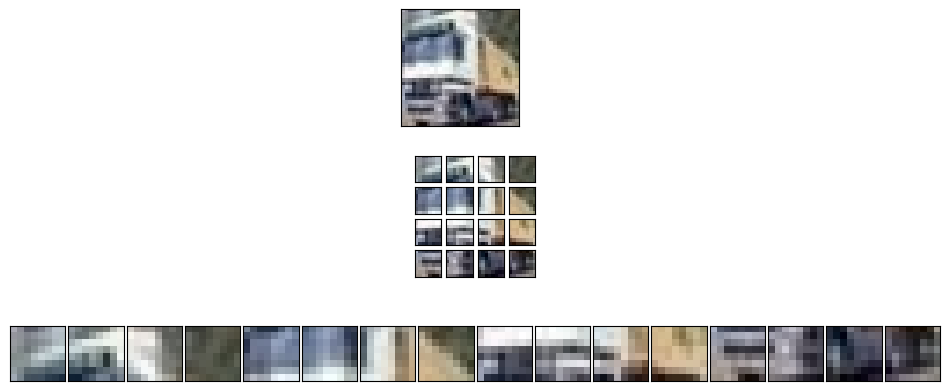

In [20]:
sample_img = read_image(df_all.iloc[0, 0])
img_plot(sample_img, patch_size)

In [21]:
if model_type == "vit":
    model = vit(
        image_size=img_size,
        patch_size=patch_size,
        num_classes=num_classes,
        dim=embed_size,
        depth=encoder_depth,
        heads=attention_heads,
        mlp_dim=mlp_dim,
        emb_dropout=0.1,
        dropout=0.1
    )
elif model_type == "swin":
    model = swin_t(window_size=patch_size,
                   num_classes=num_classes,
                   downscaling_factors=downscaling_factor
                   )
else:
    raise ValueError(
        "You must set the model_type variable to any of: vit , swin")

In [22]:
output = model(sample_img_batch)

print("Input Shape: ", sample_img_batch.size())
print("Output Shape: ", output.size())

summary(model=model,
        input_size=sample_img_batch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([256, 3, 32, 32])
Output Shape:  torch.Size([256, 2])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
vit (vit)                                          [256, 3, 32, 32]     [256, 2]             3,456                True
├─Sequential (to_patch_embedding)                  [256, 3, 32, 32]     [256, 16, 192]       --                   True
│    └─Rearrange (0)                               [256, 3, 32, 32]     [256, 16, 192]       --                   --
│    └─Linear (1)                                  [256, 16, 192]       [256, 16, 192]       37,056               True
├─Dropout (dropout)                                [256, 17, 192]       [256, 17, 192]       --                   --
├─Transformer (transformer)                        [256, 17, 192]       [256, 17, 192]       --                   True
│    └─ModuleList (layers)                         --                   --                   --                   True
│    │    └─ModuleList (0)                     

In [23]:
criterion = loss_algo()
optimizer = optimize_algo(model.parameters(), **optimize_args)
scheduler = schedule_algo(optimizer, **schedule_args)

In [24]:
if start_from_model:
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    best_acc = checkpoint['best_acc']
    list_tr_loss = checkpoint['list_tr_loss']
    list_tr_acc = checkpoint['list_tr_acc']
    list_val_loss = checkpoint['list_val_loss']
    list_val_acc = checkpoint['list_val_acc']
else:
    best_acc = 0

    list_tr_loss = []
    list_tr_acc = []
    list_val_loss = []
    list_val_acc = []

In [25]:
model.to(device)
for epoch in range(start_epoch, end_epoch):

    print(f'\n epoch: {epoch+1}/{end_epoch}')

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in  loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)


        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path (Gradient)
        loss.backward()
        # Optimizer(Adam) Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total

        loop1.set_description(f"Train--Epoch [{epoch+1}/{end_epoch}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    list_tr_loss.append(avg_tr_loss)
    list_tr_acc.append(avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{end_epoch}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)

    list_val_loss.append(avg_val_loss)
    list_val_acc.append(avg_val_accuracy)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "epoch": epoch,
                 "best_acc": best_acc,
                 "list_tr_loss": list_tr_loss,
                 "list_tr_acc": list_tr_acc,
                 "list_val_loss": list_val_loss,
                 "list_val_acc": list_val_acc
                 }
        torch.save(state, model_state_path +f'{model_type}_patch{patch_size}_cifak_epoch_{epoch}')

    ##########################################################

    if use_scheduler: scheduler.step()  # step scheduling


 epoch: 1/20


Valid--Epoch [1/20]: 100%|██████████| 89/89 [00:01<00:00, 55.70it/s, acc=49.8, loss=0.697]


Saving..

 epoch: 2/20


Valid--Epoch [2/20]: 100%|██████████| 89/89 [00:01<00:00, 55.58it/s, acc=49.6, loss=0.712]


 epoch: 3/20



Valid--Epoch [3/20]: 100%|██████████| 89/89 [00:01<00:00, 54.98it/s, acc=49.7, loss=0.738]


 epoch: 4/20



Valid--Epoch [4/20]: 100%|██████████| 89/89 [00:01<00:00, 53.72it/s, acc=49.5, loss=0.751]


 epoch: 5/20



Valid--Epoch [5/20]: 100%|██████████| 89/89 [00:01<00:00, 54.94it/s, acc=49.6, loss=0.775]


 epoch: 6/20



Valid--Epoch [6/20]: 100%|██████████| 89/89 [00:01<00:00, 53.14it/s, acc=49.6, loss=0.797]


 epoch: 7/20



Valid--Epoch [7/20]: 100%|██████████| 89/89 [00:01<00:00, 52.38it/s, acc=49.7, loss=0.817]



 epoch: 8/20


Valid--Epoch [8/20]: 100%|██████████| 89/89 [00:01<00:00, 53.00it/s, acc=49.6, loss=0.833]


 epoch: 9/20



Valid--Epoch [9/20]: 100%|██████████| 89/89 [00:01<00:00, 52.43it/s, acc=49.6, loss=0.835]


 epoch: 10/20



Valid--Epoch [10/20]: 100%|██████████| 89/89 [00:01<00:00, 52.37it/s, acc=49.7, loss=0.855]


 epoch: 11/20



Valid--Epoch [11/20]: 100%|██████████| 89/89 [00:01<00:00, 53.09it/s, acc=49.7, loss=0.864]


 epoch: 12/20



Valid--Epoch [12/20]: 100%|██████████| 89/89 [00:01<00:00, 52.50it/s, acc=49.7, loss=0.869]


 epoch: 13/20



Valid--Epoch [13/20]: 100%|██████████| 89/89 [00:01<00:00, 53.93it/s, acc=49.7, loss=0.883]


 epoch: 14/20



Valid--Epoch [14/20]: 100%|██████████| 89/89 [00:01<00:00, 50.72it/s, acc=49.7, loss=0.879]



 epoch: 15/20


Valid--Epoch [15/20]: 100%|██████████| 89/89 [00:01<00:00, 52.17it/s, acc=49.7, loss=0.88] 


 epoch: 16/20



Valid--Epoch [16/20]: 100%|██████████| 89/89 [00:01<00:00, 50.05it/s, acc=49.7, loss=0.893]


 epoch: 17/20



Valid--Epoch [17/20]: 100%|██████████| 89/89 [00:01<00:00, 51.22it/s, acc=49.8, loss=0.896]



 epoch: 18/20


Valid--Epoch [18/20]: 100%|██████████| 89/89 [00:01<00:00, 50.30it/s, acc=49.8, loss=0.901]


 epoch: 19/20



Valid--Epoch [19/20]: 100%|██████████| 89/89 [00:01<00:00, 50.79it/s, acc=49.8, loss=0.907]



 epoch: 20/20


Valid--Epoch [20/20]: 100%|██████████| 89/89 [00:01<00:00, 51.06it/s, acc=49.8, loss=0.907]


Saving..


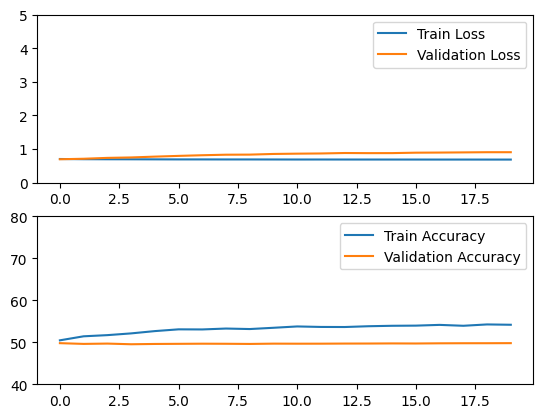

In [26]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(list_tr_loss )), list_tr_loss , label='Train Loss')
axs[0].plot(range(len(list_val_loss)), list_val_loss, label='Validation Loss')
axs[0].set_ylim([0,5])

axs[1].plot(range(len(list_tr_acc)), list_tr_acc, label='Train Accuracy')
axs[1].plot(range(len(list_val_acc)), list_val_acc, label='Validation Accuracy')
axs[1].set_ylim([40,80])

axs[0].legend()
axs[1].legend()
plt.show()